# Mechanics of running regressions

```{note}
These next few pages use a classic dataset called "diamonds" to introduce the regression methods. In lectures, we will use finance oriented data. 
```


## Objectives

After this page, 

1. You can fit a regression with `statsmodels` or `sklearn` that includes dummy variables, categorical variables, and interaction terms.
    - `statsmodels`: Nicer result tables, usually easier to specifying the regression model
    - `sklearn`: Easier to use within a prediction/ML exercise
1. With both modules: You can view the results visually
1. With both modules: You can get the coefficients, t-stats, R$^2$, Adj R$^2$, predicted values ($\hat{y}$), and residuals ($\hat{u}$)




Let's get our hands dirty quickly by loading some data.

In [1]:
# load some data to practice regressions
import seaborn as sns
import numpy as np
diamonds = sns.load_dataset('diamonds')

# this alteration is not strictly necessary to practice a regression
# but we use this in livecoding
diamonds2 = (diamonds.query('carat < 2.5')               # censor/remove outliers
            .assign(lprice = np.log(diamonds['price']))  # log transform price
            .assign(lcarat = np.log(diamonds['carat']))  # log transform carats
            .assign(ideal = diamonds['cut'] == 'Ideal') 
             
             # some regression packages want you to explicitly provide 
             # a variable for the constant
            .assign(const = 1)                           
            )  



## Our first regression with `statsmodels`

You'll see these steps repeated a lot for the rest of the class:
1. Load the module
1. Load your data, and set up your y and X variables
1. Pick the model, _usually something like:_ `model = <moduleEstimator>`
1. Fit the model and store the results, _usually something like:_ `results = model.fit()`
1. Get predicted values, _usually something like:_ `predicted = results.predict()`


In [2]:
import statsmodels.api as sm        # need this

y = diamonds2['lprice']             # pick y
X = diamonds2[['const','lcarat']]   # set up all your X vars as a matrix

# NOTICE I EXPLICITLY GIVE X A CONSTANT SO IT FITS AN INTERCEPT

model1 = sm.OLS(y,X)                # pick model type (OLS here) and specify model features
results1 = model1.fit()             # estimate / fit
print(results1.summary())           # view results (coefs, t-stats, p-vals, R2, Adj R2)
y_predicted1 = results1.predict()   # get the predicted results
residuals1 = results1.resid         # get the residuals
#residuals1 = y - y_predicted1      # another way to get the residuals
print('\n\nParams:')
print(results1.params)              # if you need to access the coefficients (e.g. to save them), results.params


                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 7.542e+05
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:06:38   Log-Likelihood:                -4073.2
No. Observations:               53797   AIC:                             8150.
Df Residuals:                   53795   BIC:                             8168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4525      0.001   6193.432      0.0

## A better way to regress with `statsmodels`

```{tip} 
This is my preferred way to run a regression in Python unless I _have_ to use sklearn.

[The documentation with tricks and examples for how to write a regression formula with statsmodels is here.](https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html)
```

In the above, replace
```python
y = diamonds2['lprice']             # pick y
X = diamonds2[['const','lcarat']]   # set up all your X vars as a matrix

model1 = sm.OLS(y,X)                # pick model type (OLS here) and specify model features
```
with this
```python
model1 = sm.OLS.from_formula('lprice ~ lcarat',data=diamonds2)  
```
which I can replace with this (after adding `from statsmodels.formula.api import ols as sm_ols` to my imports)
```python
model1 = sm_ols('lprice ~ lcarat',data=diamonds2)  
```

**WOW!** This isn't just more convenient (1 line is less than 3), I like this because 

1. You can set up the model (the equation) more naturally. Notice that I didn't set up the y and X variables as explicit variables. Simply tell that $y=a+b*X+c*Z$ by writing out `y ~ X + Z`
1. It allows you to **EASILY** include categorical variables (see below)
1. It allows you to **EASILY** include interaction effects (see below)


In [3]:
from statsmodels.formula.api import ols as sm_ols # need this

model2   = sm_ols('lprice ~ lcarat',  # specify model (you don't need to include the constant!)
                  data=diamonds2)
results2 = model2.fit()               # estimate / fit
print(results2.summary())             # view results ... identical to before
y_predicted2 = results2.predict()     # get the predicted results
residuals2 = results2.resid           # get the residuals
#residuals1 = y - y_predicted1        # another way to get the residuals
print('\n\nParams:')
print(results2.params)                # if you need to access the coefficients (e.g. to save them), results.params


                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 7.542e+05
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:06:38   Log-Likelihood:                -4073.2
No. Observations:               53797   AIC:                             8150.
Df Residuals:                   53795   BIC:                             8168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4525      0.001   6193.432      0.0

```{note}
We will cover what all these numbers mean later, but this page is focusing on the how-to.
```

## Regression with  `sklearn`

`sklearn` is pretty similar but 
- when setting up the model object, you don't tell it what data to put into the model
- you call the model object, and then fit it on data, with `model.fit(X,y)`
- it doesn't have the nice summary tables

In [4]:
from sklearn.linear_model import LinearRegression

y = diamonds2['lprice']                   # pick y
X = diamonds2[['const','lcarat']]         # set up all your X vars as a matrix

# NOTICE I EXPLICITLY GIVE X A CONSTANT SO IT FITS AN INTERCEPT

model3 = LinearRegression()               # set up the model object (but don't tell sklearn what data it gets!)   
results3 = model3.fit(X,y)                # fit it, and tell it what data to fit on
print('INTERCEPT:', results3.intercept_)  # to get the coefficients, you print out the intercept
print('COEFS:', results3.coef_)           # and the other coefficients separately (yuck)
y_predicted3 = results3.predict(X)        # get predicted y values
residuals3 = y - y_predicted3             # get residuals


INTERCEPT: 8.452511832951718
COEFS: [0.         1.68193567]


```{admonition} That's so much uglier. Why use sklearn? 
:class: warning

Because `sklearn` is the go-to for training models using more sophisticated ML ideas (which we will talk about some later in the course!). Two nice walkthroughs:
- [This guide from the PythonDataScienceHandbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html) (you can use different data though)
- The "Linear Regression" section [here](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5) shows how you can run regressions on training samples and test them out of sample
```

## Plotting the regression fit 

Once you save the predicted values ($\hat{y}$), it's easy to add it to a plot:

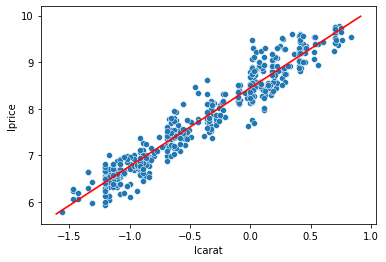

In [5]:
import matplotlib.pyplot as plt

# step 1: plot our data as you want 
sns.scatterplot(x='lcarat',y='lprice',
                data=diamonds2.sample(500,random_state=20)) # sampled just to avoid overplotting

# step 2: add the fitted regression line (the real X values and the predicted y values)
sns.lineplot(x=diamonds2['lcarat'],y=y_predicted1,color='red')

plt.show()


```{note}
`sns.lmplot` and `sns.regplot` will put a regression line on a scatterplot without having to set up and run a regression, but they also overplot the points when you have a lot of data. That's why I used the approach above - scatterplot a subsample of the data and then overlay the regression line. 

One other alternative is to use `sns.lmplot` and `sns.regplot`, but use the `x_bins` parameter to report a "binned scatterplot". Check it out if you're curious. 
```

## Including dummy variables

Suppose you started by estimating the price of diamonds as a function of carats

$$
\log(\text{price})=a+\beta_0 \log(\text{carat}) +u
$$

but you realize it will be different for ideal cut diamonds. That is, a 1 carat diamond might cost \$1,000, but if it's ideal, it's an extra \$500 dollars.

$$
\log(\text{price})=
    \begin{cases}
      a+\beta_0 \log(\text{carat}) + \beta_1 +u, & \text{if ideal cut}  \\
      a+\beta_0 \log(\text{carat}) +u, & \text{otherwise}
    \end{cases} 
$$

Notice that $\beta_0$ in this model are the same for ideal and non-ideal. 

```{tip}
**Here is how you run this test: You just add the dummy variable as a new variable in the formula!**
```

In [6]:
# ideal is a dummy variable = 1 if ideal and 0 if not ideal
print(sm_ols('lprice ~ lcarat + ideal', data=diamonds2).fit().summary())


                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 3.914e+05
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:06:44   Log-Likelihood:                -3136.4
No. Observations:               53797   AIC:                             6279.
Df Residuals:                   53794   BIC:                             6306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.4182      0.002   5415.779

<img src=https://media.giphy.com/media/zcCGBRQshGdt6/source.gif width="400">


## Including categorical variables

Dummy variables take on two values (on/off, True/False, 0/1). Categorical variables can take on many levels. "Industry" and "State" are typical categorical variables in finance applications.

$$
\log(\text{price})=
    \begin{cases}
      a+\beta_0 \log(\text{carat}) + \beta_1 +u, & \text{if premium cut}  \\
      a+\beta_0 \log(\text{carat}) + \beta_2 +u, & \text{if very good cut}  \\
      a+\beta_0 \log(\text{carat}) + \beta_3 +u, & \text{if good cut}  \\
      a+\beta_0 \log(\text{carat}) + \beta_4 +u, & \text{if fair cut}  \\
      a+\beta_0 \log(\text{carat}) +u, & \text{otherwise (i.e. ideal)}
    \end{cases} 
$$

`sm_ols` also processes categorical variables easily!

```{tip}
**Here is how you run this test: You just add the categorical variable as a new variable in the formula!**
```

```{warning}
WARNING 1: A good idea is to **ALWAYS** put your categorical variable inside of "C()" like below. This tells statsmodels that the variable should be treated as a categorical variable EVEN IF it is a number. (Which would otherwise be treated like a number.)
```

```{warning}
WARNING 2: You don't create a dummy variable for all the categories! As long as you include a constant in the regression ($a$), one of the categories is covered by the constant. Above, "ideal" is captured by the intercept. 

And if you look at the results of the next regression, the "ideal" cut level doesn't have a coefficient. **Statsmodels** automatically drops one of the categories when you use the formula approach. Nice!!!

But if you manually set up the regression in statsmodels or sklearn, you have to drop one level yourself!!!
```


In [7]:
print(sm_ols('lprice ~ lcarat + C(cut)', data=diamonds2).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.613e+05
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:06:44   Log-Likelihood:                -2389.9
No. Observations:               53797   AIC:                             4792.
Df Residuals:                   53791   BIC:                             4845.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.5209    

<img src=https://media.giphy.com/media/NaboQwhxK3gMU/source.gif width="400">


## Including interaction terms

Suppose that an ideal cut diamond doesn't just add a fixed dollar value to the diamond. Perhaps it also changes the value of having a larger diamond. You might say that 
- A high quality cut is even more valuable for a larger diamond than it is for a small diamond. ("A great cut makes a diamond sparkle, but it's hard to see sparkle on a tiny diamond no matter what.")
- In other words, the effect of carats depends on the cut and visa versa
- In other words, "the cut variable **interacts** with the carat variable"
- So you might say that, "a better cut changes the slope/coefficient of carat"
- Or equivalently, "a better cut changes the return on a larger carat"

Graphically, it's easy to see, as `sns.lmplot` by default gives each cut a unique slope on carats:

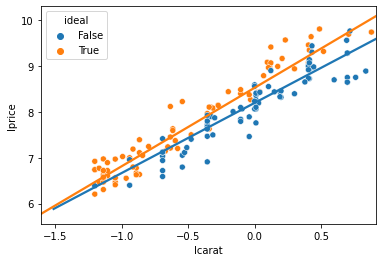

In [8]:
import matplotlib.pyplot as plt

# add reg lines to plot
fig, ax = plt.subplots()
ax = sns.regplot(data=diamonds2.query('cut == "Fair"'),
                 y='lprice',x='lcarat',scatter=False,ci=None) 
ax = sns.regplot(data=diamonds2.query('cut == "Ideal"'),
                 y='lprice',x='lcarat',scatter=False,ci=None) 

# scatter
sns.scatterplot(data=diamonds2.groupby('cut').sample(80,random_state=99).query('cut in ["Ideal","Fair"]'),
                x='lcarat',y='lprice',hue='ideal',ax=ax)
plt.show()


Those two different lines above are estimated by

$$
\log(\text{price})= a+ \beta_0 \log(\text{carat}) + \beta_1 \text{Ideal} + \beta_2\log(\text{carat})\cdot \text{Ideal}
$$

If you plug in 1 for $ideal$, you get the line for ideal diamonds as

$$
\log(\text{price})= a+ \beta_1 +(\beta_0 + \beta_2) \log(\text{carat}) 
$$

If you plug in 0 for $ideal$, you get the line for fair diamonds as

$$
\log(\text{price})= a+ \beta_0 \log(\text{carat}) 
$$

So, by including that interaction term, you get that the slope on carats is different for Ideal than Fair diamonds.

````{tip}
**Here is how you run this test: You just add the two variables as a new variable in the formula, along with one term where they are both multiplied!**

````

In [9]:
# you can include the interaction of x and z by adding "+x*z" in the spec, like:
sm_ols('lprice ~ lcarat + ideal + lcarat*ideal', data=diamonds2.query('cut in ["Fair","Ideal"]')).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 1.022e+05
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:06:44   Log-Likelihood:                -1650.8
No. Observations:               23106   AIC:                             3310.
Df Residuals:                   23102   BIC:                             3342.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.1954      0.007   1232.871      0.000       8.182       8.208
ideal[T.True]            0.3302      0.007     46.677      0.000       0.316       0.344
lcarat                   1.5282      0.015    103.832      0.000       1.499       1.557
lcarat:ideal[T.True]     0.1822      0.015     12.101      0.000       0.153       0.212
==============================================================================
Omnibus:                      117.253   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.473
Skew:                           0.097   Prob(JB):                     2.58e-32
Kurtosis:                       3.337   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This shows that a 1% increase in carats is associated with a 1.52% increase in price for fair diamonds, but a 1.71% increase for ideal diamonds (1.52+0.18).

Thus: The return on carats is different (and higher) for better cut diamonds!